# Interpretable Multivariate Forecasting with Deep Learning
## **Exercise**: _Traffic & Construction (Part 3)_
### Workshop for ML Summit — scheduled for April 19th, 2020 2:15 PM CEST
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Serg.ai](https://www.serg.ai/), [Github](https://www.serg.ai/), [Packt](https://www.packtpub.com/authors/serg-masis)) 

This notebook will walk through:

**PART III**

- With Morris Sensitivity Analysis, you will identify Factor Prioritization, which ranks factors (in other words, features) by how much they can drive output variability.
- With Sobol Sensitivity Analysis, you will compute Factor Fixing, which helps determine what factors aren't influential. It does this by quantifying the input factors' contributions and interactions to the output's variability. With this, you can understand what uncertain factors may have the most effect on potential fines and costs, thus producing a variance-based cost-sensitivity analysis.

## 1) Install Libraries
#### _(if not installed already)_

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install --upgrade pandas numpy scikit-learn statsmodels tensorflow Keras matplotlib seaborn

Always installed unless installed already:

In [ ]:
!pip install --upgrade machine-learning-datasets
!pip install --upgrade distython SALib

## 2) Preparations

Run every cell in this section:

In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")

#DATA WRANGLING
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.data_utils import get_file

#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

#MODELING
import tensorflow as tf
from tensorflow import keras

#INTERPRETATION
from sklearn import metrics
from distython import HEOM
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp
from SALib.sample import saltelli as ss
from SALib.analyze import sobol as sa
from SALib.plotting import bar as sp

Using plaidml.keras.backend backend.


In [3]:
traffic_df = mldatasets.load("traffic-volume", prepare=True)

https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data/Metro_Interstate_Traffic_Volume.csv.gz
1 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data folder
parsing /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data/Metro_Interstate_Traffic_Volume.csv.gz


In [4]:
y_scaler = MinMaxScaler()
y_scaler.fit(traffic_df[['traffic_volume']])
X_scaler = MinMaxScaler()
X_scaler.fit(traffic_df.drop(['traffic_volume'], axis=1))

MinMaxScaler()

In [5]:
lookback = 672
y_all = y_scaler.transform(traffic_df[['traffic_volume']])
X_all = X_scaler.transform(traffic_df.drop(['traffic_volume'], axis=1))
gen_all = TimeseriesGenerator(X_all, y_all, length=672, batch_size=24)
print("gen_all_678:\t%s\t×\t%s\t→\t%s" % (len(gen_all),\
                                    gen_all[0][0].shape,\
                                    gen_all[0][1].shape))

gen_all_678:	1041	×	(24, 672, 14)	→	(24, 1)


In [6]:
X_df = traffic_df.drop(['traffic_volume'], axis=1).reset_index(drop=True)

In [7]:
working_season_df = traffic_df[lookback:].drop(['traffic_volume'], axis=1).copy()
working_season_df = working_season_df[(working_season_df.index.month >= 5) &\
                                      (working_season_df.index.month <= 10)]

In [8]:
working_hrs_df = working_season_df[(working_season_df.dow < 5) &\
                                   ((working_season_df.hr < 5) |\
                                    (working_season_df.hr > 22))]

In [9]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [10]:
model_path = get_file('LSTM_traffic_672_final.hdf5',\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/LSTM_traffic_672_final.hdf5?raw=true')
lstm_traffic_mdl = keras.models.load_model(model_path)
lstm_traffic_mdl.summary()

Model: "Traffic_Bidirectional_LSTM_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bidir_LSTM (Bidirectional)   (24, 672)                 943488    
_________________________________________________________________
Dropout (Dropout)            (24, 672)                 0         
_________________________________________________________________
Dense (Dense)                (24, 1)                   673       
Total params: 944,161
Trainable params: 944,161
Non-trainable params: 0
_________________________________________________________________


In [11]:
def filt_fn(X_df, x, lookback):
    #print(x.tolist())
    x_ = x.copy()
    x_[0] = round(x_[0])
    x_[1] = round(x_[1])
    x_[4] = round(x_[4])
    x_[5] = round(x_[5])
    if x_[1] < 0:
        x_[1] = 24 + x_[1]
        x_[0] = x_[0] - 1
    if x_[0] < 0:
        x_[0] = 7 + x_[0]
    x_[6] = round(x_[6])
    x_[7] = round(x_[7])
    x_[8] = round(x_[8])
    x_[9] = round(x_[9])
    x_[10] = round(x_[10])
    x_[11] = round(x_[11])
    x_[12] = round(x_[12])
    x_[13] = round(x_[13])
    #if not (x==x_).all(): print('\t%s' % x_.tolist())
    X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
             (X_df.is_holiday==x_[5]) & (X_df.temp-5<=x_[2]) & (X_df.temp+5>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.is_holiday==x_[5]) & (X_df.temp-8<=x_[2]) & (X_df.temp+8>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.temp-11<=x_[2]) & (X_df.temp+11>=x_[2])]
    return X_filt_df, x_

In [12]:
cat_idxs = np.where(traffic_df.drop(['traffic_volume'], axis=1).dtypes != np.float64)[0]
heom_dist = HEOM(X_df.values, cat_idxs)

In [13]:
predict_fn = lambda X: mldatasets.\
                        approx_predict_ts(X, X_df, gen_all, lstm_traffic_mdl,\
                              dist_metric=heom_dist.heom, lookback=lookback,\
                              filt_fn=filt_fn, X_scaler=X_scaler, y_scaler=y_scaler)

## 3) Identifying Influential Features with Factor Prioritization

The Morris Method is one of several global sensitivity analysis methods that range from simpler Fractional Factorial to complicated Monte Carlo Filtering. Morris is somewhere in-between this spectrum, falling into two categories. It uses one-at-a-time sampling, which means that only one value changes between consecutive simulations. It's also elementary effects (EE), which means that it doesn't quantify the exact effect of a factor in a model but rather gauges its importance and relationship with other factors. 

The Morris method derives a distribution of elementary effects that it associates with an individual factor. Each EE distribution has a mean (𝜇) and a standard deviation (𝜎). These two statistics are what helps map the factors into different classifications. The mean could be negative when the model is non-monotonic, so a Morris method variation adjusts for this with absolute values (𝜇∗) so that it is more manageable to interpret. We will use this variation here.

### 3.1) Define Problem

We will include the 2.5%, 50%, and 97.5% percentiles to understand where the median and outliers lie within the "working season":

In [14]:
working_hrs_df.describe(percentiles=[.025,.5,.975]).transpose()

,count,mean,std,min,2.5%,50%,97.5%,max
dow,2232.0,1.991935,1.415458,0.00,0.00000,2.000,4.00000,4.000
hr,2232.0,5.500000,7.933780,0.00,0.00000,2.500,23.00000,23.000
temp,2232.0,16.026438,5.380406,-2.57,3.17875,16.935,24.47675,30.458
rain_1h,2232.0,0.099628,0.603634,0.00,0.00000,0.000,1.45125,10.920
cloud_coverage,2232.0,29.178763,36.701417,0.00,0.00000,1.000,90.00000,100.000
is_holiday,2232.0,0.037634,0.190353,0.00,0.00000,0.000,1.00000,1.000
weather_Clear,2232.0,0.432348,0.495513,0.00,0.00000,0.000,1.00000,1.000
weather_Clouds,2232.0,0.207885,0.405885,0.00,0.00000,0.000,1.00000,1.000
weather_Haze,2232.0,0.010753,0.103159,0.00,0.00000,0.000,0.00000,1.000
weather_Mist,2232.0,0.104391,0.305835,0.00,0.00000,0.000,1.00000,1.000


Each factor that's added to the sensitivity analysis simulation slows it down, so we will only take
the top three; that is, `weather_Clear`, `weather_Clouds`, and `weather_Rain`. These factors are specified along with the other six factors into a "problem" dictionary (`morris_problem`), which has their corresponding names, bounds, and groups. Now, bounds is critical because it denotes what ranges of values will be simulated for each factor. We will use [0,4] (Monday – Friday) for dow and [−1,4] (11p.m. – 4a.m.) for hr. The filter function automatically translates negative hours into hours from the day before so that −1 on a Tuesday is equivalent to 23 on a Monday. The rest of the bounds were informed by the percentiles. Note that groups all have factors in the same group, except for the three weather ones:

In [15]:
morris_problem = {
    # There are nine variables
    'num_vars': 9,
    # These are their names
    'names': ['dow', 'hr', 'temp', 'rain_1h',\
              'cloud_coverage', 'is_holiday',\
              'weather_Clear', 'weather_Clouds',\
              'weather_Rain'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[0, 4], # dow
               [-1, 4], # hr
               [3., 25.], # temp (C)
               [0., 1.5], # rain_1h
               [0., 90.], # cloud_coverage
               [0, 1], # is_holiday
               [0, 1], # weather_Clear 
               [0, 1], # weather_Clouds 
               [0, 1] # weather_Rain
              ],
    # Only weather is grouped together
    'groups': ['dow', 'hr', 'temp', 'rain_1h',\
              'cloud_coverage', 'is_holiday',\
               'weather', 'weather', 'weather']
}

### 3.2) Prepare Morris Samples

In addition to the dictionary, it takes a number of trajectories (`300`) and levels (`num_levels=4`). The method uses a grid with factors and levels to construct the trajectories for which inputs are randomly moved **one-at-a-time** (OAT). What is important to heed here is that more levels add more resolution to this grid, potentially making for a better analysis. However, this can be very time-consuming.

In [16]:
morris_sample = ms.sample(morris_problem, 300,\
                          num_levels=4, seed=rand)
print(morris_sample.shape)

(2400, 9)


Given that the predict function will only work with 14 factors, we should modify the samples to fill the remaining five factors with zeroes. We use zeroes because that is the median value for these features. 

In [17]:
morris_sample_mod = np.hstack((morris_sample[:,0:8],\
                       np.zeros((morris_sample.shape[0],3)),\
                       morris_sample[:,8:9],\
                       np.zeros((morris_sample.shape[0],2))))
print(morris_sample_mod.shape)

(2400, 14)


### 3.3) Generate Approximate Predictions on Samples

Same as before with SHAP:

In [18]:
%%time
morris_preds = mldatasets.\
                    approx_predict_ts(morris_sample_mod, X_df, gen_all,\
                              lstm_traffic_mdl, filt_fn=filt_fn,\
                              dist_metric=heom_dist.heom, lookback=lookback,
                              X_scaler=X_scaler, y_scaler=y_scaler,\
                              progress_bar=True)


CPU times: user 59min 26s, sys: 40min 49s, total: 1h 40min 16s
Wall time: 25min 1s


### 3.4) Computing Morris Sensitivity Indices

To produce a sensitivity analysis with SALib's analyze function, all you need is your
problem dictionary (`morris_problem`), the original Morris samples (`morris_sample`), and the predictions we just produced with those samples (`morris_preds`). There's an optional confidence interval level argument (conf_level), but the default of 95 is good. 

In [19]:
%%time
morris_sensitivities = ma.analyze(morris_problem, morris_sample,\
                                  morris_preds, print_to_console=False)

CPU times: user 13 ms, sys: 1.69 ms, total: 14.7 ms
Wall time: 13.1 ms


### 3.3) Analyzing the Elementary Effects

`analyze` will return a dictionary with the Morris sensitivity indices, including the mean (𝜇) and standard deviation (𝜎) elementary effect, as well as the absolute value of the mean (𝜇∗). It's easier to appreciate these values in a tabular format so that we can place them into a DataFrame and sort and color-code them according to 𝜇∗, which can be interpreted as the overall importance of the factor. 𝜎, on the other hand, is how much the factor interacts with other ones.

You can tell that `is_holiday` surprisingly becomes the second-most important factor although not by a huge margin, at least during the bounds specified in the problem definition (`morris_problem`). Another thing to note is that weather does have an absolute mean elementary effect but inconclusive interaction effects. Groups are challenging to assess, especially when they are sparse binary factors:

In [20]:
morris_df = pd.DataFrame({'features':morris_sensitivities['names'],\
                          'μ':morris_sensitivities['mu'],\
                          'μ*':morris_sensitivities['mu_star'],\
                          'σ':morris_sensitivities['sigma']})
morris_df.sort_values('μ*', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['μ*'])

,features,μ,μ*,σ
1,hr,-429.300049,1455.506958,1544.544312
5,is_holiday,-345.794891,379.520508,588.769958
0,dow,130.311508,336.568512,554.439880
2,temp,62.087788,202.984299,422.309845
6,weather,nan,75.732869,nan
3,rain_1h,-2.807382,30.730104,113.262093
4,cloud_coverage,9.897445,17.152800,74.320007


The bar plot on the left ranks the factors by 𝜇∗, while the lines sticking out of each bar signify their corresponding confidence bands. The covariance plot to the right is a scatter plot with 𝜇∗ on the x-axis and 𝜎 on the y-axis. Therefore, the farther right the point is, the more important it is, while the further up it is in the plot, the more it interacts with other factors and becomes increasingly less monotonic. Naturally, this means that factors that don't interact much and are mostly monotonic ones comply with linear regression assumptions, such as linearity and multicollinearity. However, the spectrum between linear and non-linear or non-monotonic is determined diagonally by the ratio between 𝜎 and 𝜇∗:

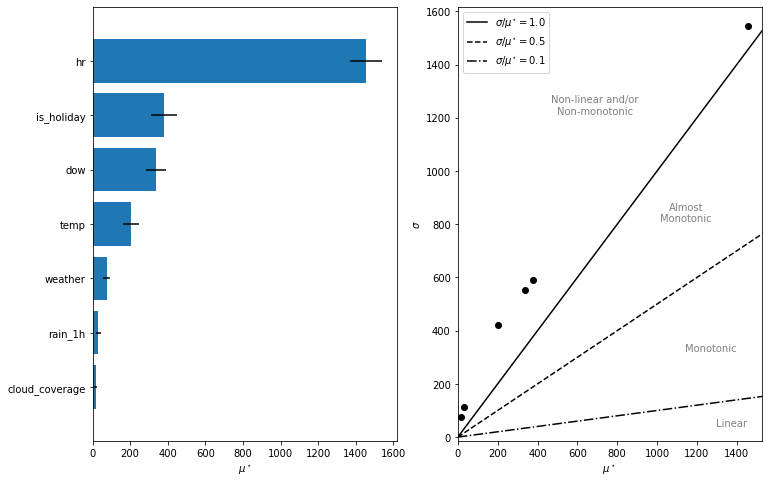

In [21]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,8))
mp.horizontal_bar_plot(ax0, morris_sensitivities, {})
mp.covariance_plot(ax1, morris_sensitivities, {})
ax1.text(ax1.get_xlim()[1]*0.45, ax1.get_ylim()[1]*0.75,\
         'Non-linear and/or\nNon-monotonic',\
         horizontalalignment='center', color='gray')
ax1.text(ax1.get_xlim()[1]*0.75, ax1.get_ylim()[1]*0.5,\
         'Almost\nMonotonic', horizontalalignment='center',\
         color='gray')
ax1.text(ax1.get_xlim()[1]*0.83, ax1.get_ylim()[1]*0.2,\
         'Monotonic', horizontalalignment='center', color='gray')
ax1.text(ax1.get_xlim()[1]*0.9, ax1.get_ylim()[1]*0.025,\
         'Linear', horizontalalignment='center', color='gray')
plt.show()

Elementary effects help us understand how to classify our factors in accordance with their effects on model outcomes. However, it's not a robust method to properly quantify their effects or those derived from factor interactions. For that, we would have to turn to a variance-based global method that uses a probabilistic framework to decompose the output's variance and trace it back to the inputs.

## 4) Quantifying Uncertainty and Cost-Sensitivity with Factor Fixing

Only variance-based methods can quantify these effects in a statistically rigorous fashion. Sobol Sensitivity Analysis is one of these methods, which means that it decomposes the model's output variance into percentages and attributes it to the model's inputs and interactions. Like Morris, it has a sampling step, as well as a sensitivity index estimation step.

Unlike Morris, the sampling doesn't follow a series of levels but the input data's distribution. It uses a quasi-Monte Carlo method, where it samples points in hyperspace that follow the inputs' probability distributions. Monte Carlo methods are a family of algorithms that perform random sampling, often for optimization or simulation. They seek to cut corners on problems that would be impossible to solve with brute force or entirely deterministic approaches. Monte Carlo methods are common in sensitivity analysis precisely for this reason. Quasi-Monte Carlo methods have the same goal. However, they converge faster because they use a deterministic low-discrepancy sequence instead of using a pseudorandom one. The Sobol method uses the Sobol sequence, devised by the same mathematician. We will use another sampling scheme derived from Sobol's, called Saltelli's.

### 3.1) Define Problem

Just as we did with Morris but with expanded bounds and less factors:

In [22]:
sobol_problem = {
    'num_vars': 7,
    'names': ['dow', 'hr', 'temp', 'rain_1h',\
              'cloud_coverage', 'is_holiday',\
              'weather_Clear'],
    'bounds': [[0, 4], # dow
               [-1, 4], # hr
               [-3., 31.], # temp (C)
               [0., 11.], # rain_1h
               [0., 100.], # cloud_coverage
               [0, 1], # is_holiday
               [0, 1] # weather_Clear
              ],
    'groups': None
}

### 3.2) Prepare Salteli Samples

Just as we did with Morris but with `calc_second_order=True`:

In [23]:
saltelli_sample = ss.sample(sobol_problem, 300, calc_second_order=True,\
                     seed=rand)
saltelli_sample_mod = np.hstack((saltelli_sample,\
                       np.zeros((saltelli_sample.shape[0],7))))
print(saltelli_sample_mod.shape)

(4800, 14)


### 3.3) Generate Approximate Predictions on Samples

Just as we did with Morris:

In [24]:
%%time
saltelli_preds = mldatasets.\
                    approx_predict_ts(saltelli_sample_mod, X_df, gen_all,\
                              lstm_traffic_mdl, filt_fn=filt_fn,\
                              dist_metric=heom_dist.heom, lookback=lookback,
                              X_scaler=X_scaler, y_scaler=y_scaler,\
                              progress_bar=True)


CPU times: user 1h 49min 15s, sys: 1h 15min 1s, total: 3h 4min 17s
Wall time: 44min 1s


### 3.4) Performing a Sobol Sensitivity Analysis

Sure, there's variance in the predicted traffic, but that traffic is only a problem once it exceeds 1,500. Uncertainty is something you want to relate to risk or reward, costs or revenue, loss or profit – something tangible you can connect to your problem. Let's make sure that the highest traffic prediction with the samples exceeds this amount:

In [25]:
print(max(saltelli_preds[:,0]))

1879.7686


Instead of using the predictions (`saltelli_preds`) as the model's output, we can create a simple binary array with ones when it exceeded 1,500 and zero otherwise. We will call this costs, and then run the `analyze` function with it. Note that `calc_second_order=True` is also set here too. 

In [26]:
%%time
costs = np.where(saltelli_preds > 1500, 1,0)[:,0]
factor_fixing_sa = sa.analyze(sobol_problem, costs,\
                      calc_second_order=True, print_to_console=False)

CPU times: user 38.7 ms, sys: 1.11 ms, total: 39.8 ms
Wall time: 38.7 ms


`analyze` will return a dictionary with the Sobol sensitivity indices, including the first- order (S1), second-order (S2), and total-order (ST) indices, as well as the total confidence bounds (ST_conf). The indices correspond to percentages, but the totals won't necessarily add up unless the model is additive.

In [27]:
sobol_df = pd.DataFrame({'features':sobol_problem['names'],\
                          '1st':factor_fixing_sa['S1'],\
                          'Total':factor_fixing_sa['ST'],\
                          'Total Conf':factor_fixing_sa['ST_conf'],\
                          'Mean of Input':saltelli_sample.mean(axis=0)[0:7]})
sobol_df.sort_values('Total', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['Total'])

,features,1st,Total,Total Conf,Mean of Input
1,hr,0.009185,0.886824,0.912979,1.495931
2,temp,0.006123,0.506757,0.660847,14.059766
0,dow,0.009185,0.380068,0.366337,1.995599
5,is_holiday,0.003062,0.380068,0.479628,0.498047
6,weather_Clear,-0.003062,0.126689,0.314201,0.499023
3,rain_1h,0.000000,0.000000,0.000000,5.511458
4,cloud_coverage,0.000000,0.000000,0.000000,50.024740


You can tell that `temp` and `is_holiday` are in the top four, at least during the bounds specified in the problem definition (`sobol_problem`). Another thing to note is that `weather_Clear` does have more of an effect on its own, but `rain_1h` and `cloud_coverage` seem to have no effect on the potential cost.

Something interesting about the first-order values is how low they are, suggesting that interactions account for most of the model output variance. We can easily produce a heatmap with second-order indices to corroborate this. It's the combination of these indices and the first-order ones that add up to the totals.

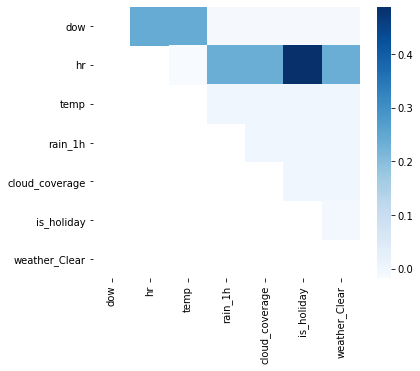

In [28]:
plt.figure(figsize=(6, 5))
sns.heatmap(factor_fixing_sa['S2'], cmap='Blues',\
            xticklabels=sobol_problem['names'],\
            yticklabels=sobol_problem['names'])
plt.show()

Here, you can tell that `is_holiday` and `hr` are the two factors that contribute the most to the output variance. `hr` has sizable interactions with all the factors except `temp`, but `dow` does so with `hr` and `temp`.

### 3.5) Incorporating a Realistic Cost Function

Now, we can create a cost function that takes our inputs (saltelli_sample) and outputs (saltelli_preds) and computes how much the twin cities would fine the construction company, plus any additional costs the additional traffic could produce. It is better to do this if both the input and outputs are in the same array because we will need details from both to calculate the costs. 

In [29]:
#Join input and outputs into a sample+prediction array
saltelli_sample_preds = np.hstack((saltelli_sample, saltelli_preds))

We know that the half-capacity threshold wasn't exceeded for any sample predictions, so we won't even bother to include the daily penalty in the function. Besides that, the fines are \\$15 per vehicle that exceeds the hourly no-construction threshold. In addition to these fines, to be able to leave on time, the construction company estimates additional costs: \\$1,500 in extra wages if the threshold is exceeded at 4 a.m. and \\$4,500 more on Fridays to speed up the move of their equipment because it can't stay on the highway shoulder during weekends.

In [30]:
#Define cost function
def cost_fn(x):
    cost = 0
    if x[7] > 1500:
        cost = (x[7] - 1500) * 15
        if round(x[1]) == 4:
            cost = cost + 1500
            if round(x[0]) == 4:    
                cost = cost + 4500
    return cost

#Use list comprehension to compute costs for sample+prediction array
costs2 = np.array([cost_fn(xi) for xi in saltelli_sample_preds])

#Print total fines for entire sample predictions
print(sum(costs2)) 

119014.43481445312


The print statement should output a cost somewhere between \\$110-130 thousand. But not to worry! The construction crew only plans to work about 180 days on-site per year and 5 hours each day, for a total of 900 hours. However, there are 4,800 samples, which means that there's over 5 years' worth of predicted costs due to excess traffic. In any case, the point of calculating these costs is to figure out how they relate to the model's inputs. More years' worth of samples means tighter confidence intervals.

We can now perform the analysis again but with `costs2`, and we can save the analysis into a `factor_fixing2_sa` dictionary.

In [31]:
%%time
factor_fixing2_sa = sa.analyze(sobol_problem, costs2,\
                       calc_second_order=True, print_to_console=False)

CPU times: user 34.2 ms, sys: 659 µs, total: 34.8 ms
Wall time: 34.3 ms


As you can tell by the following image, once the actual costs have been factored in, `is_holiday` becomes the riskiest factor and `dow` becomes more important too, while the last three factors retain their positions from before.

In [32]:
sobol2_df = pd.DataFrame({'features':sobol_problem['names'],\
                          '1st':factor_fixing2_sa['S1'],\
                          'Total':factor_fixing2_sa['ST'],\
                          'Total Conf':factor_fixing2_sa['ST_conf'],\
                          'Mean of Input':saltelli_sample.mean(axis=0)[0:7]})
sobol2_df.sort_values('Total', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['Total'])

,features,1st,Total,Total Conf,Mean of Input
5,is_holiday,0.000852,0.953683,3.509316,0.498047
1,hr,0.010101,0.748595,1.132662,1.495931
2,temp,0.000677,0.552892,0.843213,14.059766
0,dow,0.009874,0.514826,0.452778,1.995599
6,weather_Clear,-0.002776,0.121222,0.404479,0.499023
3,rain_1h,0.000000,0.000000,0.000000,5.511458
4,cloud_coverage,0.000000,0.000000,0.000000,50.024740


One thing that is hard to appreciate with a table is the confidence intervals of the sensitivity indices. For that, we can use a bar plot, but first, we must convert the entire dictionary into a DataFrame so that SALib's plotting function can plot it:

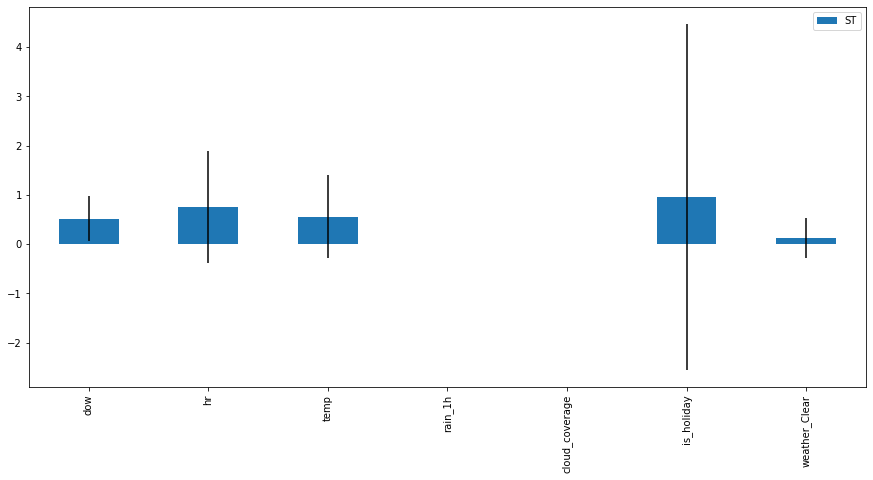

In [33]:
factor_fixing2_df = factor_fixing2_sa.to_df()
fig, (ax) = plt.subplots(1,1, figsize=(15, 7))
sp.plot(factor_fixing2_df[0], ax=ax)
plt.show()

The preceding code generates the following bar plot. The 95% confidence interval for is_ holiday is much larger than for other important factors, which shouldn't be surprising considering that the model was trained with fewer instances of holidays (only 3% of days are holidays). Another interesting insight is how weather_Clear has negative first- order effects, so the positive total-order indices are entirely attributed to second-order ones, which expand the confidence interval.

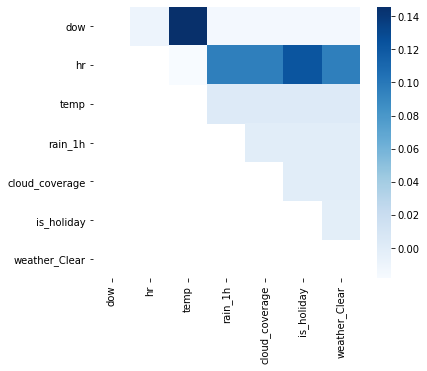

In [34]:
plt.figure(figsize=(6, 5))
sns.heatmap(factor_fixing2_sa['S2'], cmap='Blues',\
            xticklabels=sobol_problem['names'],\
            yticklabels=sobol_problem['names'])
plt.show()

The preceding heatmap shows similar salient interactions to those from before but they're much more nuanced since there are more shades. It becomes evident that there's negligible interaction between `hr` and `temp`, and that there are smaller second-order effects between `dow` and `hr` than between `dow` and `temp`. Meanwhile, `hr` still interacts with every other factor except `temp`, but effects are less stark between `is_holiday` and the others.

## 4) Conclusion

The mission was to train a traffic prediction model and understand what factors create uncertainty and possibly increase costs for the construction company. We can conclude that a large portion of the potential \\$20,000/year in fines can be attributed to the is_ holiday factor. Therefore, the construction company should rethink working holidays. There are only five or six holidays between May and October, and they could cost more because of the fines than working on a few Sundays instead. Of course, these conclusions are for the chosen model – which we can compare with other, better models. With this caveat, the mission was successful, but there's still a lot of room for improvement.